### Question 1
#### (P) Find the top 5 ranked airports in the state of New York. Present results in a similar form to what was done for the state of California|Table 3.6.

In [1011]:
datadir = '../Datasets/'

In [1012]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [1013]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [1014]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
D.head()

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [1015]:
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
A.head()

,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [1016]:
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
A.head()
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

464 nodes and 12000 directed edges


In [1020]:
## Build smaller subgraph for New york 
hva = [v for v in g.vs() if v['state'] == 'NY']
G = g.subgraph(hva)
G.vcount()

17

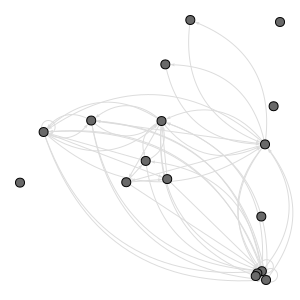

In [1021]:
## plot using lat/lon as layout
ly = ig.Layout(G.vs['layout'])
ly.mirror(1)
ig.plot(G, bbox=(0,0,300,300), layout=ly)

In [1022]:
## compute normalized weights 
#####weight is the traffic for airport
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

In [1023]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in G.strength(weights=weights)]
    return dc

In [1024]:
## compute centrality measures
C = pd.DataFrame({'airport':G.vs()['name'],\
                  'degree':degree_centrality(G,weights='normalized_weight'),\
                  'pagerank':G.pagerank(weights='weight'),'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),'between':G.betweenness(),\
                  'closeness':G.closeness()})
## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)
df = Cs.head()
df

,airport,degree,pagerank,authority,hub,between,closeness
0,JFK,0.129888,0.327591,1.000000,0.408982,0.356250,0.188235
2,BUF,0.076250,0.187059,0.285791,1.000000,0.092361,0.188235
4,ROC,0.041181,0.104569,0.154652,0.547064,0.000000,0.183908
5,SYR,0.033720,0.092804,0.124650,0.459323,0.134028,0.190476
1,LGA,0.030048,0.103628,0.213494,0.086202,0.157639,0.190476


### Question 2
#### (P) Generate Chung-Lu graph G(w) on n = 10;000 nodes and power-law degree distribution using the set of weights prescribed by (2.6) with   gamma = 2:5, delta = 1, and traingle =sqreroot(n) = 100. (We experimented with this model in Section 2.5.) For each centrality measure (degree, pagerank, authority, hub, between, closeness) compute f(k), the average centrality measure over all vertices of degree k. Plot f(k) as a function of k. Is there any visible correlation between a given centrality measure and degree of a node?

In [1025]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [1026]:
## power law graph
import numpy as np
gamma = 2.5
n = 10000
delta = 1
Delta = np.sqrt(n)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = [int(np.round(w)) for w in W]


m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)

g1 = ig.Graph.TupleList(tpl, directed = True)
g1.es['weight'] = W

In [1027]:
## compute normalized weights 
#####weight is the traffic for airport
mw = np.max(g1.es['weight'])
g1.es()['normalized_weight'] = [w/mw for w in g1.es()['weight']]

In [1028]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g1.strength(mode='in',weights=weights),\
              g1.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g1.strength(weights=weights)]
    return dc

In [1029]:
## compute several centrality measures
C = pd.DataFrame({'name':g1.vs()['name'],\
                  'degree':degree_centrality(g1,weights='normalized_weight'),\
                  'pagerank':g1.pagerank(weights='weight'),'authority':g1.authority_score(weights='weight'),\
                  'hub':g1.hub_score(weights='weight'),'between':g1.betweenness(),\
                  'closeness':g1.closeness()})
## normalize betweenness
n = g1.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)

df = Cs
df

,name,degree,pagerank,authority,hub,between,closeness
25,0,2.801565e-04,0.000081,0.000000e+00,6.432939e-06,0.000000,0.002759
4,1,2.325277e-04,0.000081,0.000000e+00,5.229234e-04,0.000000,0.002758
65,10,2.250582e-04,0.000083,3.943196e-08,2.341545e-06,0.000203,0.002758
121,5,2.173379e-04,0.000094,4.094158e-06,1.593526e-04,0.000105,0.002759
33,13,2.068239e-04,0.000085,8.638799e-05,1.418812e-06,0.000029,0.002758
...,...,...,...,...,...,...,...
7042,7682,6.351930e-07,0.000177,0.000000e+00,0.000000e+00,0.000000,0.002738
7043,3355,6.351507e-07,0.000081,0.000000e+00,2.995142e-15,0.000000,0.002730
7044,7599,6.351084e-07,0.000084,2.019200e-06,0.000000e+00,0.000000,0.002746
7045,6306,6.350661e-07,0.000082,1.347639e-09,0.000000e+00,0.000000,0.002751


In [1030]:
deg = g1.degree()
d5 = pd.DataFrame(deg)
df

,name,degree,pagerank,authority,hub,between,closeness
25,0,2.801565e-04,0.000081,0.000000e+00,6.432939e-06,0.000000,0.002759
4,1,2.325277e-04,0.000081,0.000000e+00,5.229234e-04,0.000000,0.002758
65,10,2.250582e-04,0.000083,3.943196e-08,2.341545e-06,0.000203,0.002758
121,5,2.173379e-04,0.000094,4.094158e-06,1.593526e-04,0.000105,0.002759
33,13,2.068239e-04,0.000085,8.638799e-05,1.418812e-06,0.000029,0.002758
...,...,...,...,...,...,...,...
7042,7682,6.351930e-07,0.000177,0.000000e+00,0.000000e+00,0.000000,0.002738
7043,3355,6.351507e-07,0.000081,0.000000e+00,2.995142e-15,0.000000,0.002730
7044,7599,6.351084e-07,0.000084,2.019200e-06,0.000000e+00,0.000000,0.002746
7045,6306,6.350661e-07,0.000082,1.347639e-09,0.000000e+00,0.000000,0.002751


In [1031]:
d5['deg'] = d5[0]
d5['name'] = g1.vs()['name']
del d5[0]
d6 = d5.merge(Cs)
d7 = d6.groupby('deg').agg({"degree":'mean',"pagerank":'mean','authority': 'mean','hub': 'mean', 'between': 'mean', 'closeness': 'mean' }).reset_index()
d7

,deg,degree,pagerank,authority,hub,between,closeness
0,1,0.000002,0.000112,2.579721e-04,1.551215e-08,0.000000e+00,0.002424
1,2,0.000004,0.000136,3.480963e-06,1.090137e-07,2.652190e-07,0.002702
2,3,0.000007,0.000148,1.205395e-05,8.430576e-08,7.635887e-07,0.002747
3,4,0.000008,0.000144,1.638838e-03,1.102397e-08,1.928471e-06,0.002748
4,5,0.000010,0.000139,4.273509e-07,8.911382e-07,3.232838e-06,0.002749
...,...,...,...,...,...,...,...
58,77,0.000188,0.000083,2.866908e-05,1.620298e-06,1.296401e-04,0.002759
59,83,0.000217,0.000094,4.094158e-06,1.593526e-04,1.048844e-04,0.002759
60,84,0.000179,0.000081,0.000000e+00,9.346193e-07,0.000000e+00,0.002758
61,86,0.000218,0.000082,9.958389e-06,2.626652e-04,3.003293e-05,0.002759


### Correlation between degree of node and closeness

Text(0.5, 1.0, 'Degree of node and Closeness centrality measure')

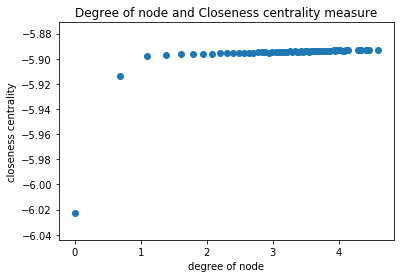

In [1032]:
plt.scatter(np.log(d7['deg']),np.log(d7['closeness']))
plt.xlabel("degree of node")
plt.ylabel("closeness centrality")
plt.title("Degree of node and Closeness centrality measure")

The graph shows positive correaltion between degree of nodes and closeness centrality measure

### Correlation between degree of node and pagerank

Text(0.5, 1.0, 'Degree of node and Pagerank centrality measure')

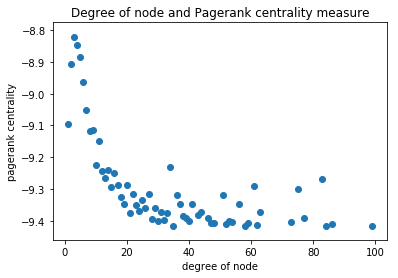

In [1033]:
plt.scatter(d7['deg'],np.log(d7['pagerank']))
plt.xlabel("degree of node")
plt.ylabel("pagerank centrality")
plt.title("Degree of node and Pagerank centrality measure")

The graph shows negative correaltion between degree of nodes and pagerank centrality measure

### Correlation between degree of node and betweenness centrality measure

/Users/user/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Degree of node and Betweenness centrality measure')

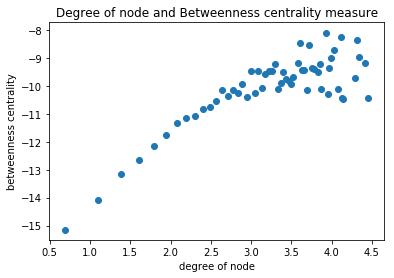

In [1034]:
plt.scatter(np.log(d7['deg']),np.log(d7['between']))
plt.xlabel("degree of node")
plt.ylabel("betweenness centrality")
plt.title("Degree of node and Betweenness centrality measure")

The graph shows positive correaltion between degree of nodes and betwenness centrality measure

### Correlation between degree of node and hub centrality measure

Text(0.5, 1.0, 'Degree of node and Hub centrality measure')

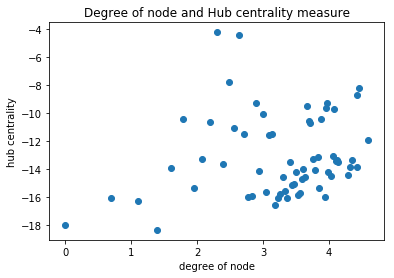

In [1035]:
plt.scatter(np.log(d7['deg']),np.log(d7['hub']))
plt.xlabel("degree of node")
plt.ylabel("hub centrality")
plt.title("Degree of node and Hub centrality measure")

The graph shows low negative correaltion between degree of nodes and hub centrality measure

### Correlation between degree of node and authority centrality measure

Text(0.5, 1.0, 'Degree of node and Authority centrality measure')

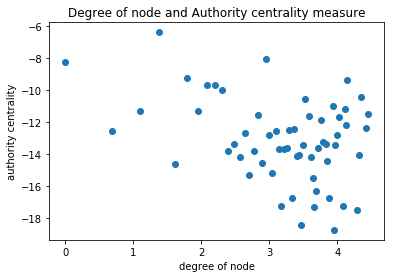

In [1036]:
plt.scatter(np.log(d7['deg']),np.log(d7['authority']))
plt.xlabel("degree of node")
plt.ylabel("authority centrality")
plt.title("Degree of node and Authority centrality measure")

The graph shows low negative correaltion between degree of nodes and authority centrality measure

### Correlation between degree of node and degree centrality measure

Text(0.5, 1.0, 'Degree of node and Degree centrality measure')

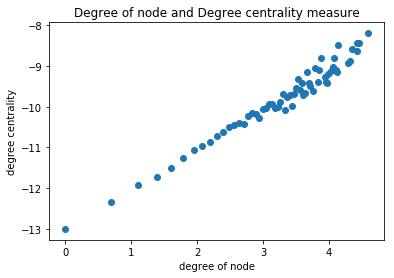

In [1037]:
plt.scatter(np.log(d7['deg']),np.log(d7['degree']))
plt.xlabel("degree of node")
plt.ylabel("degree centrality")
plt.title("Degree of node and Degree centrality measure")

The graph shows highly positive correaltion between degree of nodes and degree centrality measure

### Question 3
#### The original airport dataset (464 nodes, 12{,}000 directed weighted edges) is not strongly connected but it is almost weakly connected. There are two weak components: the giant one consisting of all but two airports, and the small one with two airports that only link to each other. Remove the two nodes to make the graph weakly connected. For each centrality measure (degree, pagerank, authority, hub, between, closeness) perform the following experiment. Sort all nodes with respect to a given centrality measure. How many nodes with the largest score do we need to remove to so that the graph is no longer weakly connected? Compare this with the number of nodes with the smallest score that need to be removed.

In [1038]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
D.head()

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [1039]:
#create a graph
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed = True, edge_attrs = ['weight'])
g.vcount()

464

In [1040]:
#find the weakest componenets in the graph
a = g.clusters(mode = "weak").membership
b = pd.DataFrame(a)
b

,0
0,0
1,0
2,0
3,0
4,0
...,...
459,0
460,1
461,1
462,0


In [1041]:
#delete the weakest components from the graph
g.delete_vertices([460,461])
g.vcount()

462

In [1042]:
#The graph is weakly connected now
g.is_connected(mode="weak")

True

In [1043]:
mw = np.max(g.es['weight'])
g.es()['normalized_weight'] = [w/mw for w in g.es()['weight']]

In [1044]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [1045]:
## compute several centrality measures
C = pd.DataFrame({'airport':g.vs()['name'],\
                  'degree':degree_centrality(g,weights='normalized_weight'),\
                  'pagerank':g.pagerank(weights='weight'),'authority':g.authority_score(weights='weight'),\
                  'hub':g.hub_score(weights='weight'),'between':g.betweenness(),\
                  'closeness':g.closeness()})
## normalize betweenness
n = g.vcount()

C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by="degree")
df = Cs.copy()
df.head()

,airport,degree,pagerank,authority,hub,between,closeness
461,EKX,7.520941e-10,0.000337,0.000000e+00,3.287565e-12,0.0,0.319031
460,AID,7.520941e-10,0.000337,3.968855e-08,0.000000e+00,0.0,0.356811
459,MOP,1.504188e-09,0.000337,1.403685e-09,0.000000e+00,0.0,0.322378
457,FDY,1.504188e-09,0.000337,4.505835e-08,0.000000e+00,0.0,0.362992
454,ADS,1.504188e-09,0.000337,0.000000e+00,4.875513e-09,0.0,0.316404


#### Perform experiment of removing nodes to make the graph disconnected .

#### Sorting nodes to disconnect the graph using degree as centreality measure

In [1046]:
ds1 = D.copy()
df = df.sort_values(by='degree', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with smallest degree centrality score is", (462 - g2.vcount()))

Number of nodes removed with smallest degree centrality score is 179


In [1047]:
ds1 = D.copy()
df = df.sort_values(by='degree', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with largest degree centrality score is", (462 - g2.vcount()))

Number of nodes removed with largest degree centrality score is 2


#### Sorting nodes to disconnect the graph using pagerank as centreality measure

In [1048]:
ds1 = D.copy()
df = df.sort_values(by='pagerank', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with smallest pagerank centrality score is", (462 - g2.vcount()))

Number of nodes removed with smallest pagerank centrality score is 36


In [1049]:
ds1 = D.copy()
df = df.sort_values(by='pagerank', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with largest pagerank centrality score is", (462 - g2.vcount()))

Number of nodes removed with largest pagerank centrality score is 2


#### Sorting nodes to disconnect the graph using authority as centreality measure

In [1050]:
ds1 = D.copy()
df = df.sort_values(by='authority', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with smallest authority centrality score is", (462 - g2.vcount()))

Number of nodes removed with smallest authority centrality score is 2


In [1051]:
ds1 = D.copy()
df = df.sort_values(by='authority', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with largest authority centrality score is", (462 - g2.vcount()))

Number of nodes removed with largest authority centrality score is 2


#### Sorting nodes to disconnect the graph using hub as centreality measure

In [1052]:
ds1 = D.copy()
df = df.sort_values(by='hub', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with smallest hub centrality score is", (462 - g2.vcount()))

Number of nodes removed with smallest hub centrality score is 462


In [1053]:
ds1 = D.copy()
df = df.sort_values(by='hub', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with largest hub centrality score is", (462 - g2.vcount()))

Number of nodes removed with largest hub centrality score is 2


#### Sorting nodes to disconnect the graph using betweenness as centreality measure

In [1054]:
ds1 = D.copy()
df = df.sort_values(by='between', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with smallest between centrality score is", (462 - g2.vcount()))

Number of nodes removed with smallest between centrality score is 462


In [1055]:
ds1 = D.copy()
df = df.sort_values(by='between', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with largest between centrality score is", (462 - g2.vcount()))

Number of nodes removed with largest between centrality score is 4


#### Sorting nodes to disconnect the graph using closeness as centreality measure

In [1056]:
ds1 = D.copy()
df = df.sort_values(by='closeness', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with smallest closeness centrality score is", (462 - g2.vcount()))

Number of nodes removed with smallest closeness centrality score is 462


In [1057]:
ds1 = D.copy()
df = df.sort_values(by='closeness', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([460,461])
for i, row in df.iterrows():
    air = row['airport']
    if g2.is_connected(mode='weak') == True:
        g2.delete_vertices(air)
print("Number of nodes removed with largest closeness centrality score is", (462 - g2.vcount()))

Number of nodes removed with largest closeness centrality score is 1


### Question 4
(P) Generate binomial random graphs G(n; p) with n 2 f{1;250; 2;500; 5;000; 10;000; 20;000}g and the expected degree pn from the set f{1; 2; 4; 8; 16}g. For each centrality measure (degree, pagerank, authority, hub, between, closeness) estimate the time required to compute it. What can you say about the scalability of the algorithms under the implementation you have used? Try to estimate the complexity of such algorithms.

In [1058]:
## directed degree centrality
def degree_centrality(G, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in G.strength(weights=weights)]
    return dc

In [1059]:
import time
n = 1250
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)

degree computation time 0.0007338523864746094
pagerank computation time 0.004827022552490234
authority_score computation time 0.0060882568359375
hub_score computation time 0.005476951599121094
betweenness computation time 0.2435009479522705
closeness computation time 0.10491704940795898


In [1060]:
import time
n = 2500
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)

degree computation time 0.0005178451538085938
pagerank computation time 0.009791851043701172
authority_score computation time 0.009800910949707031
hub_score computation time 0.008991241455078125
betweenness computation time 1.10080885887146
closeness computation time 0.5190050601959229


In [1061]:
import time
n = 5000
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
    
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)

degree computation time 0.0015859603881835938
pagerank computation time 0.024655818939208984
authority_score computation time 0.059187889099121094
hub_score computation time 0.022439956665039062
betweenness computation time 4.260309934616089
closeness computation time 1.9499738216400146


In [1062]:
import time
n = 10000
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)


degree computation time 0.001961946487426758
pagerank computation time 0.036187171936035156
authority_score computation time 0.036724090576171875
hub_score computation time 0.03206300735473633
betweenness computation time 20.59398078918457
closeness computation time 13.30803394317627


In [1063]:
import time
n = 20000
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)

degree computation time 0.0030977725982666016
pagerank computation time 0.06956100463867188
authority_score computation time 0.10280203819274902
hub_score computation time 0.21473217010498047
betweenness computation time 192.25944805145264
closeness computation time 55.454102993011475


#### The time complexity for degree centrality measure can be estimated as O(V) 
#### The time complexity for pagerank centrality measure can be estimated as O(k*V)
#### The time complexity for authority centrality measure can be estimated as O(V)
#### The time complexity for hub centrality measure can be estimated as O(V)
#### The time complexity for betweenness centrality measure can be estimated as O(V*E)
#### The time complexity for closeness centrality measure can be estimated as O(V/E)